# Raport: Wykrywanie anomalii w rzeczywistych zbiorach danych

##### Wykonał: Andrii Sonsiadlo
##### Nr albumu: 245576


W celu przeprowadzenia eksperymentów z wykrywaniem anomalii, wybrano zbiory danych o różnych rozmiarach i wymiarach.
Statystyki opisowe dla każdego zbioru zostały przedstawione w następnej częci raportu.
Dla wykonania eksperymentów na wybranych metodach zbiory danych byli podzielone na zbiory treningowy i testowy w proporcji 1:1.

| Dataset | Description             | Size  |  DIM  | OOD           |
|---------|-------------------------|-------|:-----:|---------------|
| Thyroid | Thyroid disease         | 3772  |   6   | 93 (2.47 %)   |
| Shuttle | Shuttle landing control | 49097 |   9   | 3511 (7.15 %) |
| Vowels  | Vowels recognition      | 1456  |  12   | 50 (3.43 %)   |

Każdy z tych zbiorów danych różni się pod względem rozmiaru i liczby cech, ale również w zakresie wartości odstających, które stanowią różny procent całego zbioru. Zbiór Shuttle zawiera najwięcej wartości odstających, a zbiór Thyroid - najmniej.


Wykorzystane algorytmy do wykrywania anomalii:
- *Isolation Forest*
- *Local Outlier Factor*
- *Support Vector Machine*

Zastosowane metryki dla określenia jakości algorytmów:
- __*Accuracy*__ - stosunek liczby poprawnie sklasyfikowanych przypadków do liczby wszystkich przypadków w zbiorze danych. Metryka ta jest przydatna do oceny ogólnego poziomu dokładności modelu, ale może nie działać dobrze w przypadku niezrównoważonych zbiorów danych.
- __*Precision*__ - stosunek liczby przypadków poprawnie sklasyfikowanych jako pozytywne do liczby wszystkich przypadków sklasyfikowanych jako pozytywne. Metryka ta mierzy, jak dobrze model radzi sobie z identyfikowaniem pozytywnych przypadków i jest przydatna, gdy ważniejsze jest uniknięcie fałszywie pozytywnych wyników.
- __*Recall*__ - stosunek liczby przypadków poprawnie sklasyfikowanych jako pozytywne do liczby wszystkich rzeczywistych pozytywnych przypadków w zbiorze danych. Metryka ta mierzy, jak dobrze model radzi sobie z wykrywaniem rzeczywistych pozytywnych przypadków i jest przydatna, gdy ważniejsze jest uniknięcie fałszywie negatywnych wyników.
- __*F1*__ - średnia harmoniczna między __*precision*__ i __*recall*__. Ta metryka łączy w sobie te dwie metryki, aby zapewnić bardziej zrównoważoną ocenę jakości modelu.
- __*ROC*__ - wykres przedstawiający zależność między dwoma wskaźnikami: TPR (True Positive Rate) i FPR (False Positive Rate).
  - __*TPR*__ - stosunek liczby poprawnie sklasyfikowanych przypadków pozytywnych do liczby wszystkich przypadków pozytywnych w zbiorze danych
  - __*FPR*__ - stosunek liczby przypadków fałszywie sklasyfikowanych jako pozytywne do liczby wszystkich przypadków negatywnych w zbiorze danych
- __*AUC*__ - to pole powierzchni pod krzywą ROC i daje ogólny pomiar jakości klasyfikacji. Metryka ta określa zdolność modelu do rozróżniania między klasami i jest przydatna do porównywania różnych modeli. Im wyższe AUC, tym lepszy model.

Zbiory danych zostały pobrane z: [link](http://odds.cs.stonybrook.edu/)

### Importing libraries

In [1]:
%matplotlib widget

from collections import defaultdict
from typing import Optional

import numpy as np
import pandas as pd
import scipy.io
import seaborn as sns
from matplotlib import pyplot as plt
from pandas import DataFrame
from pydantic import BaseModel
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.svm import OneClassSVM


### Configuring pandas

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1200)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

### Loading datasets

In [3]:
from pydantic import Field


class DF(DataFrame):
    @classmethod
    def __get_validators__(cls):
        yield cls.validate

    @classmethod
    def validate(cls, v):
        if not isinstance(v, DataFrame):
            raise ValueError('Expected DataFrame from pandas')
        return v

    def __repr__(self):
        return f'DataFrame({super().__repr__()})'

    def __str__(self):
        return f'DataFrame({super().__str__()})'


class Dataset(BaseModel):
    class Config:
        arbitrary_types_allowed = True
        repr_html = True
        validate_assignment = True

    name: str
    x: DF = Field(repr=False)
    y: DF = Field(repr=False)

    x_train: Optional[DF]
    y_train: Optional[DF]
    x_test: Optional[DF]
    y_test: Optional[DF]

    y_pred: Optional[DF]
    scores_pred: Optional[DF]

    def split_data(self):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=0.5,
                                                                                shuffle=True)
        return self

In [4]:
from sklearn.preprocessing import StandardScaler


def load_datasets(dataset_names: tuple, verbose: bool = False):
    datasets = defaultdict(Dataset)
    for dataset_name in dataset_names:
        raw_data = scipy.io.loadmat(f'../datasets/{dataset_name}.mat')

        x = np.array(raw_data.get('X'))
        y = np.array(raw_data.get('y')).ravel().astype(dtype=np.uint8)

        x = StandardScaler().fit_transform(x)

        # TODO: split into train and test dataset, use splitted datasets in experiments
        dataset = Dataset(
            name=dataset_name,
            x=DataFrame(x, columns=[f'x{i}' for i in range(1, x.shape[1] + 1)]),
            y=DataFrame(y, columns=["class"]),
        ).split_data()
        if verbose:
            print(
                f"Name: {dataset.name}\n"
                f"X: {dataset.x.shape}\n"
                f"Y: {dataset.y.shape}\n"
                f"OOD: {(ood := np.count_nonzero(dataset.y == 1))} ({round((ood * 100) / len(dataset.y), 2)} %)\n"
            )
        datasets[dataset_name] = dataset
    return datasets


DATASET_NAMES = ('thyroid', 'shuttle', 'vowels')
datasets = load_datasets(dataset_names=DATASET_NAMES, verbose=True)

Name: thyroid
X: (3772, 6)
Y: (3772, 1)
OOD: 93 (2.47 %)

Name: shuttle
X: (49097, 9)
Y: (49097, 1)
OOD: 3511 (7.15 %)

Name: vowels
X: (1456, 12)
Y: (1456, 1)
OOD: 50 (3.43 %)



### Statistics functions

In [5]:
def accuracy_report(dataset: Dataset):
    print("Accuracy Score :", accuracy_score(dataset.y_test, dataset.y_pred))
    print("Classification Report :\n", classification_report(dataset.y_test, dataset.y_pred))

In [6]:
def corr_map_plot(dataset: Dataset, figsize=(20, 20)):
    # get correlations of each features in dataset
    corrmat = dataset.x.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=figsize)
    plt.title(f"Correlation map for {dataset.name.capitalize()} dataset")
    #plot heat map
    g = sns.heatmap(dataset.x[top_corr_features].corr(), annot=True, cmap="RdYlGn")
    plt.show()
    plt.close()

In [7]:
def conf_matrix_plot(dataset: Dataset):
    cm = confusion_matrix(dataset.y_test, dataset.y_pred)
    df_cm = pd.DataFrame(cm, index = [0, 1],
                  columns = [0, 1])
    plt.figure(figsize = (4,4))
    s = sns.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
    s.set(xlabel='Predicted label', ylabel='True label', title=f"Confusion matrix for {dataset.name.capitalize()} dataset")
    plt.show()
    plt.close()

In [8]:
def roc_curve_plot(datasets: dict[str, Dataset] | Dataset):
    if isinstance(datasets, Dataset):
        datasets = {datasets.name: datasets}

    plt.figure(figsize=(7,7))
    for name, dataset in datasets.items():
        fpr, tpr, thresh = roc_curve(dataset.y_test, dataset.scores_pred)
        auc = roc_auc_score(dataset.y_test, dataset.scores_pred)
        plt.plot(tpr, fpr, label=f"Dataset: {dataset.name}, auc={round(1 - auc, 3)}")

    plt.plot([0, 1], [0, 1], "k--")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc=0)
    plt.show()
    plt.close()

In [9]:
%matplotlib widget

def plot_3d(dataset: Dataset, dims: tuple[int, int, int]):
    x_index = dims[0]
    y_index = dims[1]
    z_index = dims[2]

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(dataset.x.iloc[:, x_index], dataset.x.iloc[:, y_index], dataset.x.iloc[:, z_index], c=dataset.y, cmap='rainbow')
    ax.set_xlabel(dataset.x.columns[x_index])
    ax.set_ylabel(dataset.x.columns[y_index])
    ax.set_zlabel(dataset.x.columns[z_index])
    plt.show()
    plt.close()

# Datasets

## Thyroid dataset

In [10]:
thyroid = datasets["thyroid"]
thyroid.x.head()

,x1,x2,x3,x4,x5,x6
0,1.134,-0.179,-0.700,0.340,-0.929,1.070
1,-1.452,-0.194,1.322,1.007,1.811,-0.064
2,-0.238,-0.123,0.513,-0.182,1.704,-0.960
3,0.659,-0.166,-0.430,-0.907,-0.499,-0.751
4,-1.504,-0.194,0.783,0.891,-0.499,1.279


In [11]:
thyroid.x.describe()

,x1,x2,x3,x4,x5,x6
count,3.772e+03,3772.000,3.772e+03,3.772e+03,3.772e+03,3.772e+03
mean,4.050e-16,0.000,-3.278e-16,2.675e-16,-1.582e-16,1.498e-16
std,1.000e+00,1.000,1.000e+00,1.000e+00,1.000e+00,1.000e+00
min,-2.665e+00,-0.204,-2.654e+00,-3.082e+00,-4.314e+00,-3.230e+00
25%,-8.185e-01,-0.179,-4.301e-01,-5.593e-01,-5.528e-01,-5.122e-01
50%,1.314e-01,-0.136,5.506e-02,-8.080e-02,-1.550e-02,-6.431e-02
75%,8.174e-01,-0.101,3.785e-01,4.267e-01,4.144e-01,3.537e-01
max,2.242e+00,22.537,1.155e+01,9.330e+00,7.131e+00,1.499e+01


array([[<Axes: title={'center': 'x1'}>, <Axes: title={'center': 'x2'}>,
        <Axes: title={'center': 'x3'}>, <Axes: title={'center': 'x4'}>,
        <Axes: title={'center': 'x5'}>, <Axes: title={'center': 'x6'}>]],
      dtype=object)

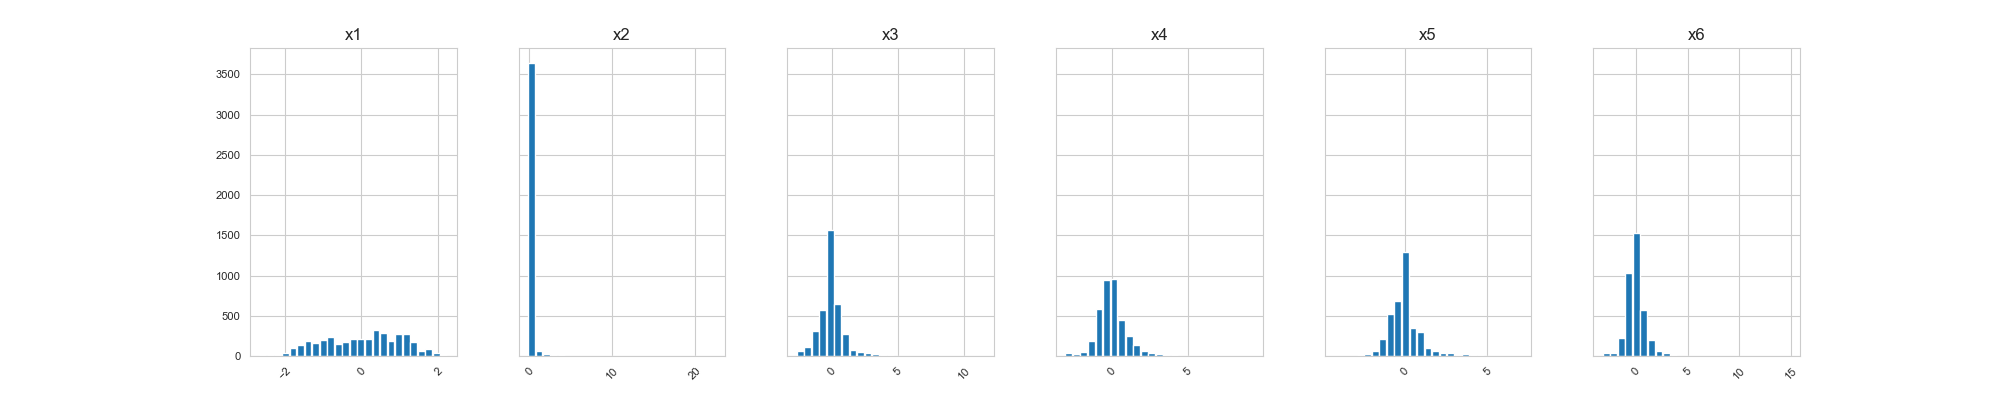

In [12]:
thyroid.x.hist(figsize=(20, 4), bins=25, xlabelsize=8, ylabelsize=8, xrot=45, layout=(1, 6), sharey=True, zorder=2,
               rwidth=0.9)

In [13]:
thyroid.y.describe()

,class
count,3772.000
mean,0.025
std,0.155
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,1.000


In [14]:
thyroid.y.value_counts()

class
0        3679
1          93
Name: count, dtype: int64

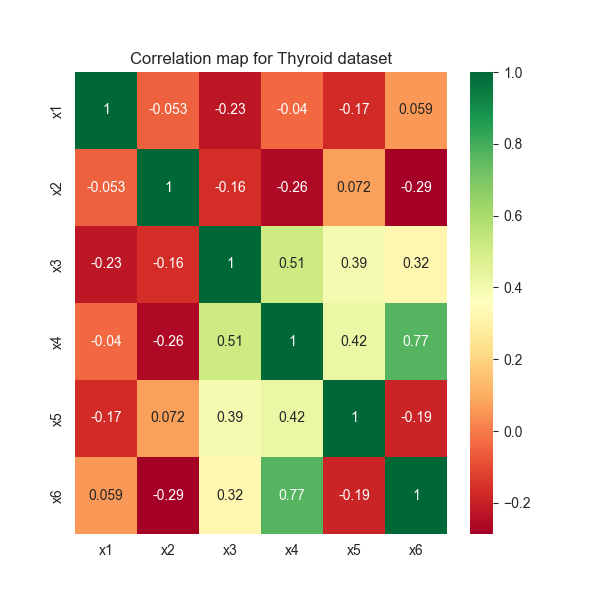

In [15]:
corr_map_plot(thyroid, figsize=(6, 6))

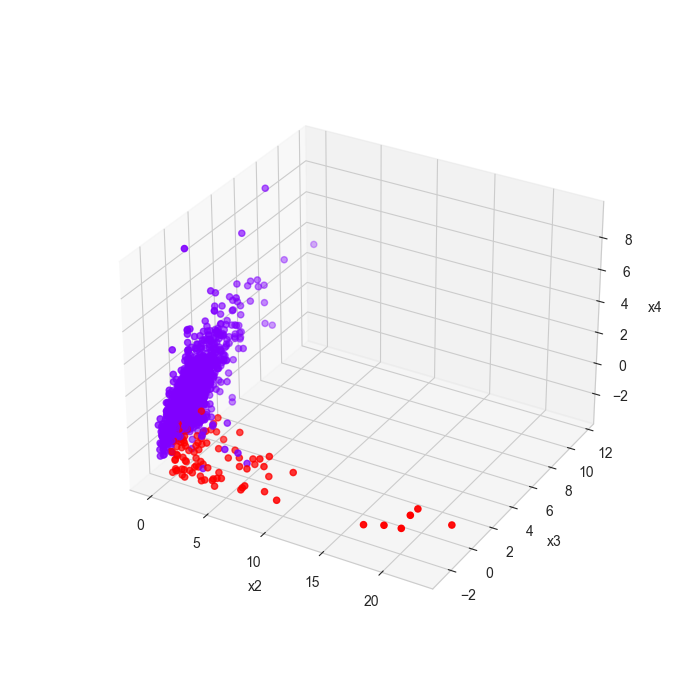

In [16]:
plot_3d(thyroid, dims=(1, 2, 3))

## Shuttle dataset

In [17]:
shuttle = datasets["shuttle"]
shuttle.x.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,0.238,2.488e-01,-0.915,-0.006,-0.444,-0.010,-0.833,-0.014,0.494
1,0.471,7.553e-04,-0.352,-0.006,0.758,-0.033,-0.684,-0.889,-0.348
2,-0.771,7.553e-04,-1.028,-0.006,-0.444,0.073,0.134,-0.014,-0.095
3,-0.771,7.553e-04,-0.690,-0.006,-0.144,-0.129,0.357,-0.111,-0.348
4,2.957,7.553e-04,0.324,-0.112,-1.546,-0.005,-2.618,1.687,2.936


In [18]:
shuttle.x.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9
count,4.910e+04,4.910e+04,4.910e+04,4.910e+04,4.910e+04,4.910e+04,4.910e+04,4.910e+04,4.910e+04
mean,1.515e-16,2.316e-18,-6.136e-17,4.052e-18,1.857e-16,3.329e-18,1.187e-17,-1.395e-16,-2.721e-17
std,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00
min,-1.548e+00,-5.694e+01,-7.223e+00,-1.048e+02,-1.126e+01,-1.225e+02,-6.411e+00,-1.951e+01,-1.542e+01
25%,-7.714e-01,7.553e-04,-6.897e-01,-5.674e-03,-3.442e-01,-2.822e-02,-3.868e-01,-6.460e-01,-4.321e-01
50%,-2.278e-01,7.553e-04,-2.392e-01,-5.674e-03,2.569e-01,-9.894e-03,5.944e-02,-3.543e-01,-3.479e-01
75%,2.383e-01,7.553e-04,3.241e-01,-5.674e-03,4.573e-01,1.301e-02,3.569e-01,3.262e-01,-1.794e-01
max,6.141e+00,5.994e+01,7.195e+00,1.019e+02,1.999e+01,6.945e+01,4.968e+00,1.078e+01,1.077e+01


array([[<Axes: title={'center': 'x1'}>, <Axes: title={'center': 'x2'}>,
        <Axes: title={'center': 'x3'}>, <Axes: title={'center': 'x4'}>,
        <Axes: title={'center': 'x5'}>, <Axes: title={'center': 'x6'}>,
        <Axes: title={'center': 'x7'}>, <Axes: title={'center': 'x8'}>,
        <Axes: title={'center': 'x9'}>]], dtype=object)

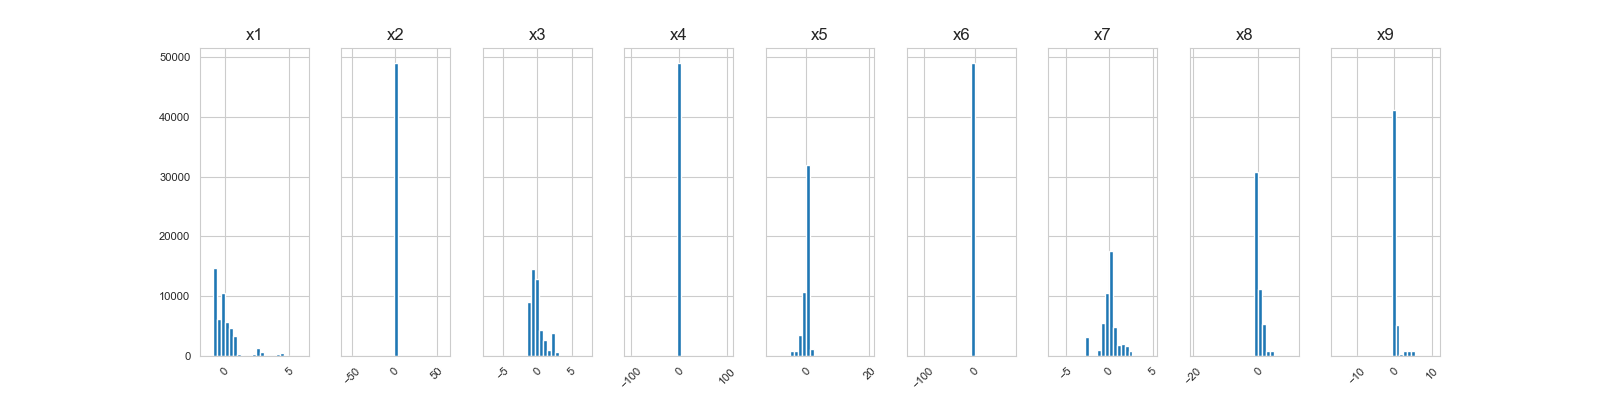

In [19]:
shuttle.x.hist(figsize=(16, 4), bins=25, xlabelsize=8, ylabelsize=8, xrot=45, layout=(1, 9), sharey=True)

In [20]:
shuttle.y.describe()

,class
count,49097.000
mean,0.072
std,0.258
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,1.000


In [21]:
shuttle.y.value_counts()

class
0        45586
1         3511
Name: count, dtype: int64

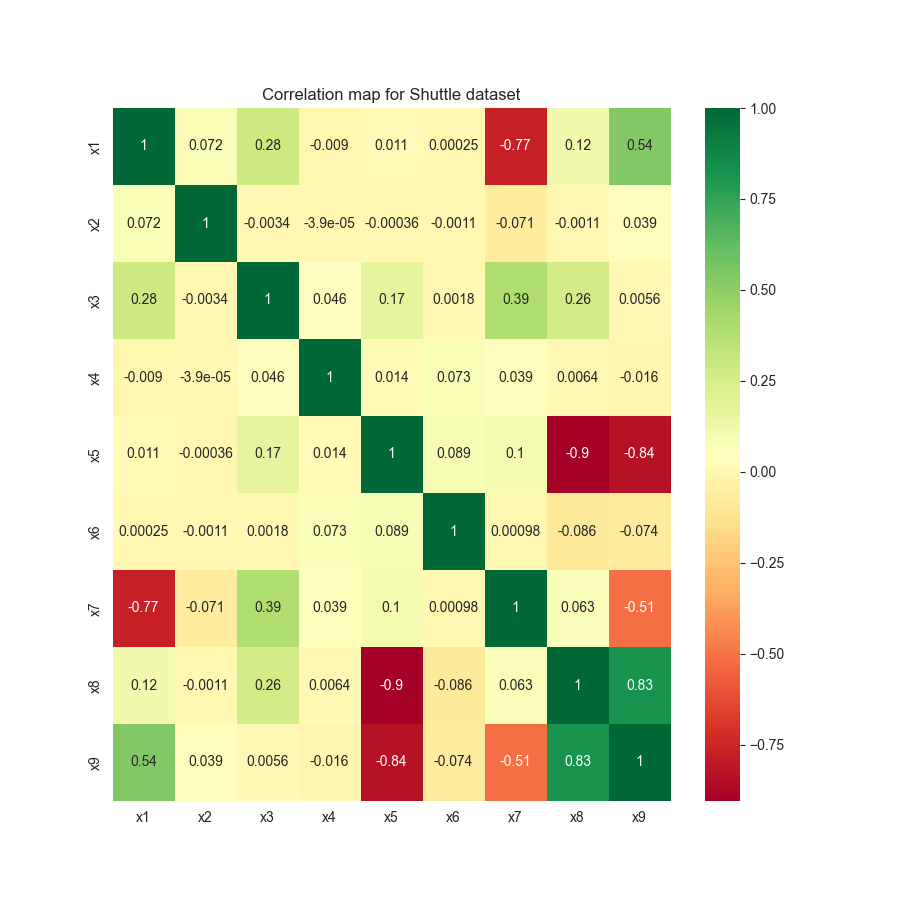

In [22]:
corr_map_plot(shuttle, figsize=(9, 9))

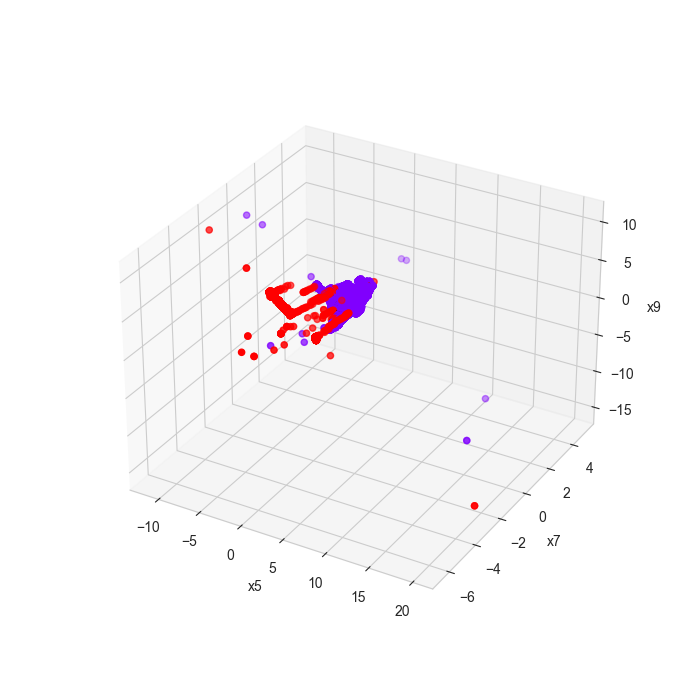

In [23]:
plot_3d(shuttle, dims=(4, 6, 8))

## Vowels dataset

In [24]:
vowels = datasets["vowels"]
vowels.x.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
0,0.581,-0.903,0.618,-0.998,-2.465,-0.847,2.351,0.376,-0.650,1.605,-0.623,-0.383
1,0.785,-1.078,0.616,-0.922,-2.389,-0.638,2.107,0.361,-0.715,1.261,-0.423,-0.288
2,0.792,-1.087,0.670,-0.806,-2.262,-0.539,2.054,0.267,-0.843,1.082,-0.267,-0.172
3,1.218,-1.084,0.856,-0.725,-2.156,-0.102,1.769,0.303,-1.045,0.656,0.214,-0.342
4,1.066,-1.031,0.774,-0.452,-1.957,0.248,1.531,0.254,-0.969,-0.208,0.332,0.007


In [25]:
vowels.x.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
count,1456.000,1.456e+03,1.456e+03,1456.000,1.456e+03,1456.000,1.456e+03,1.456e+03,1.456e+03,1456.000,1.456e+03,1.456e+03
mean,0.000,-3.904e-17,-1.171e-16,0.000,-3.904e-17,0.000,-3.904e-17,1.952e-17,3.904e-17,0.000,-9.760e-18,1.952e-17
std,1.000,1.000e+00,1.000e+00,1.000,1.000e+00,1.000,1.000e+00,1.000e+00,1.000e+00,1.000,1.000e+00,1.000e+00
min,-2.868,-2.699e+00,-2.205e+00,-2.185,-3.137e+00,-3.489,-3.044e+00,-2.330e+00,-1.673e+00,-3.078,-3.366e+00,-3.176e+00
25%,-0.703,-7.999e-01,-8.440e-01,-0.807,-6.361e-01,-0.656,-6.195e-01,-7.643e-01,-9.563e-01,-0.676,-5.773e-01,-5.841e-01
50%,0.013,-4.554e-02,1.080e-01,-0.032,5.697e-02,0.052,-1.074e-01,-3.722e-02,-6.763e-02,-0.039,9.035e-02,8.081e-02
75%,0.717,8.470e-01,8.515e-01,0.789,7.768e-01,0.711,5.369e-01,6.627e-01,8.739e-01,0.661,7.177e-01,6.745e-01
max,3.648,2.307e+00,2.255e+00,2.912,2.690e+00,3.037,3.562e+00,3.224e+00,2.539e+00,3.934,2.362e+00,3.210e+00


array([[<Axes: title={'center': 'x1'}>, <Axes: title={'center': 'x2'}>,
        <Axes: title={'center': 'x3'}>, <Axes: title={'center': 'x4'}>,
        <Axes: title={'center': 'x5'}>, <Axes: title={'center': 'x6'}>,
        <Axes: title={'center': 'x7'}>, <Axes: title={'center': 'x8'}>,
        <Axes: title={'center': 'x9'}>, <Axes: title={'center': 'x10'}>,
        <Axes: title={'center': 'x11'}>, <Axes: title={'center': 'x12'}>]],
      dtype=object)

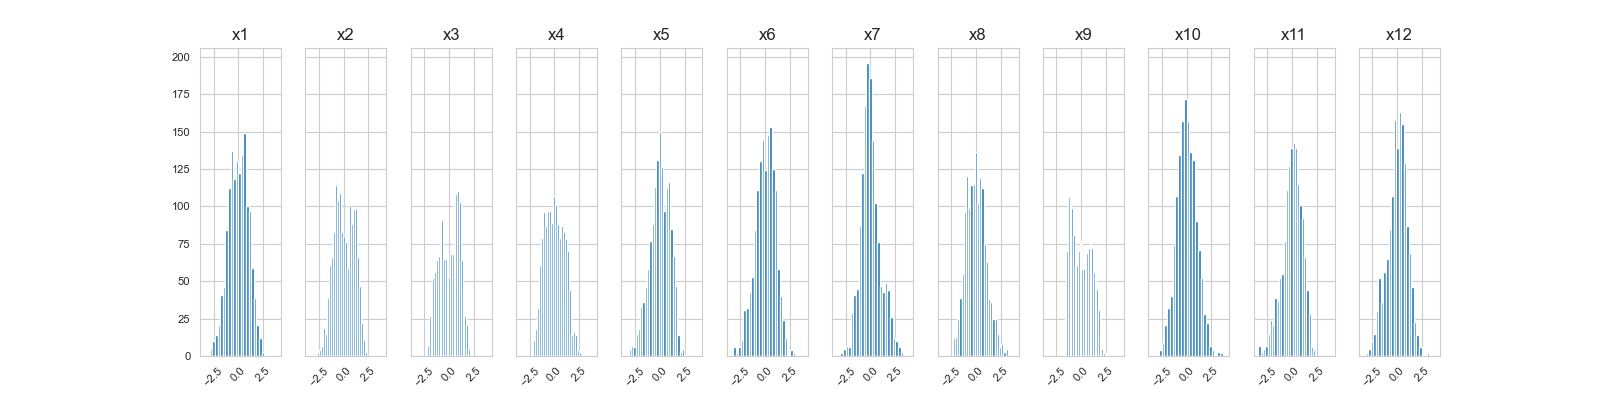

In [26]:
vowels.x.hist(figsize=(16, 4), bins=25, xlabelsize=8, ylabelsize=8, xrot=45, layout=(1, 12), sharey=True, sharex=True)

In [27]:
vowels.y.describe()

,class
count,1456.000
mean,0.034
std,0.182
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,1.000


In [28]:
shuttle.y.value_counts()

class
0        45586
1         3511
Name: count, dtype: int64

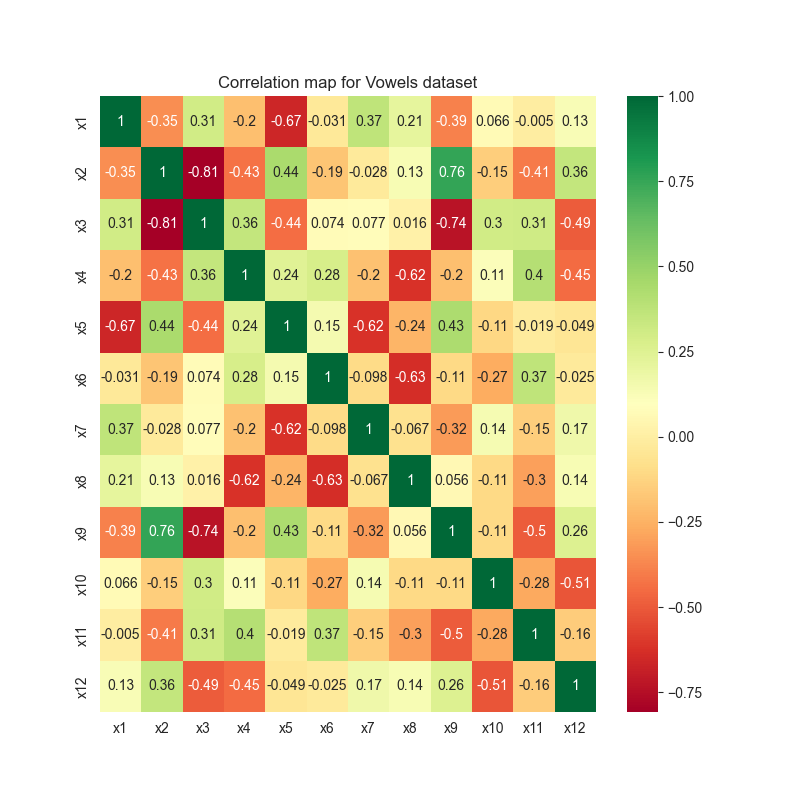

In [29]:
corr_map_plot(vowels, figsize=(8, 8))

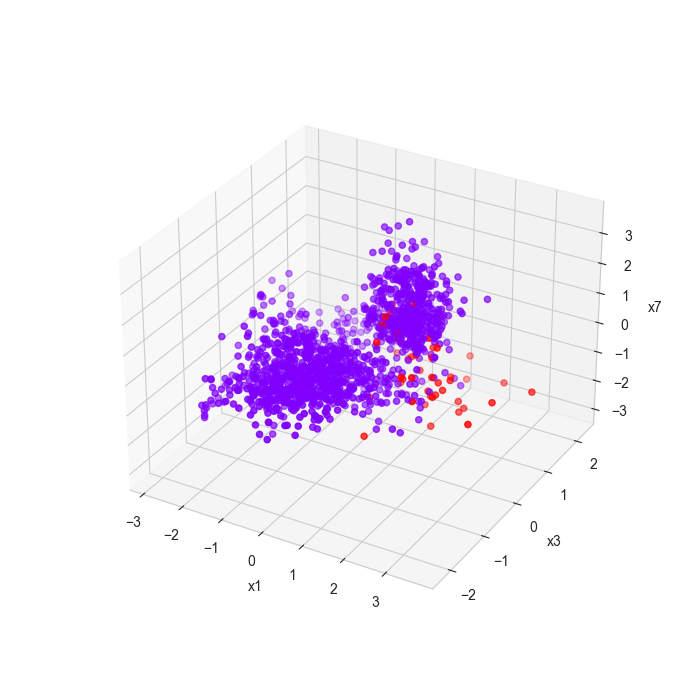

In [30]:
plot_3d(vowels, dims=(0, 2, 6))

# Experiments

## Local Outlier Factor

In [31]:
def preprocess_y(y: np.ndarray):
    return np.where(y == 1, 0, 1)

In [32]:
def local_outlier_factor(dataset: Dataset):
    print(f"{' DATASET ' + dataset.name.upper() + ' ':*^100}\n")
    model = LocalOutlierFactor(n_neighbors=20, contamination='auto', leaf_size=30, p=5)
    # model = LocalOutlierFactor(
    #     n_neighbors=20, algorithm='auto',
    #     leaf_size=30, metric='minkowski',
    #     p=2, metric_params=None, contamination='auto'
    # )
    model.fit(dataset.x_train)
    dataset.y_pred = DataFrame(preprocess_y(model.fit_predict(dataset.x_test)), columns=["class"])
    dataset.scores_pred = DataFrame(model.negative_outlier_factor_)

In [33]:
datasets = load_datasets(dataset_names=DATASET_NAMES, verbose=False)

for dataset in datasets.values():
    local_outlier_factor(dataset)
    accuracy_report(dataset)

***************************************** DATASET THYROID ******************************************

Accuracy Score : 0.9411452810180275
Classification Report :
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      1841
           1       0.15      0.31      0.20        45

    accuracy                           0.94      1886
   macro avg       0.57      0.63      0.59      1886
weighted avg       0.96      0.94      0.95      1886

***************************************** DATASET SHUTTLE ******************************************

Accuracy Score : 0.9121349138457778
Classification Report :
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     22800
           1       0.23      0.10      0.14      1749

    accuracy                           0.91     24549
   macro avg       0.58      0.54      0.55     24549
weighted avg       0.88      0.91      0.90     24549

********************

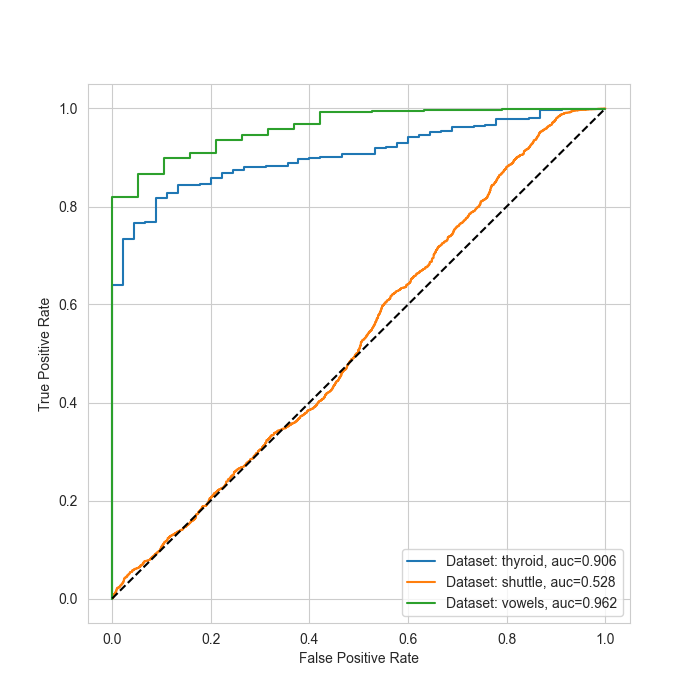

In [34]:
roc_curve_plot(datasets)

# Isolation Forest

In [35]:
def isolation_forest(dataset: Dataset):
    print(f"{' DATASET ' + dataset.name.upper() + ' ':*^100}\n")
    model = IsolationForest(
        n_estimators=200,
        max_samples="auto",
        contamination="auto"
    )
    model.fit(dataset.x)
    dataset.y_pred = DataFrame(preprocess_y(model.predict(dataset.x_test)))
    dataset.scores_pred = DataFrame(model.decision_function(dataset.x_test))


In [36]:
datasets = load_datasets(dataset_names=DATASET_NAMES, verbose=False)

for name, dataset in datasets.items():
    isolation_forest(dataset)
    accuracy_report(dataset)

***************************************** DATASET THYROID ******************************************

Accuracy Score : 0.9162248144220573
Classification Report :
               precision    recall  f1-score   support

           0       1.00      0.92      0.96      1841
           1       0.21      0.93      0.35        45

    accuracy                           0.92      1886
   macro avg       0.61      0.92      0.65      1886
weighted avg       0.98      0.92      0.94      1886

***************************************** DATASET SHUTTLE ******************************************

Accuracy Score : 0.9540103466536315
Classification Report :
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     22845
           1       0.60      0.99      0.75      1704

    accuracy                           0.95     24549
   macro avg       0.80      0.97      0.86     24549
weighted avg       0.97      0.95      0.96     24549

********************

#### ROC curve

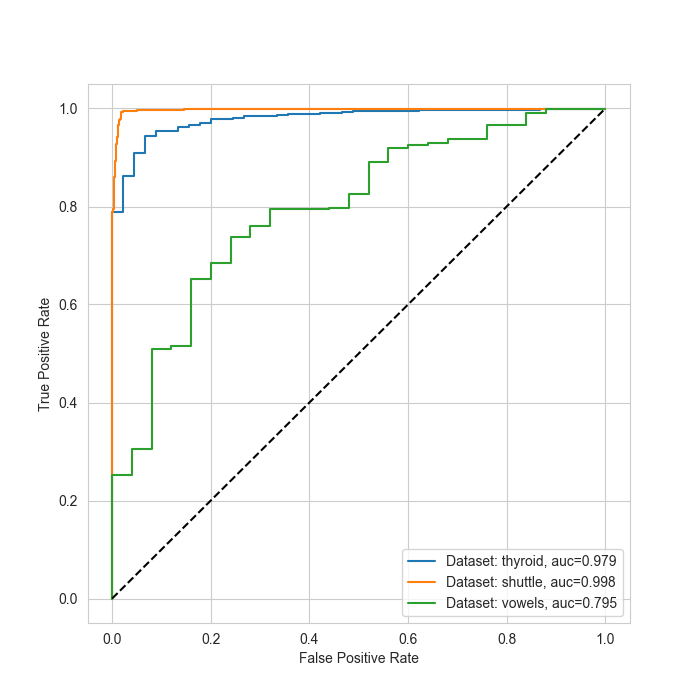

In [37]:
roc_curve_plot(datasets)

## One-Class SVM

In [38]:
def svm(dataset: Dataset):
    print(f"{' DATASET ' + dataset.name.upper() + ' ':*^100}\n")
    model = OneClassSVM(kernel='rbf', nu=0.2)
    model.fit(dataset.x_train)

    dataset.scores_pred = DataFrame(model.decision_function(dataset.x_test))

    threshold = np.percentile(dataset.scores_pred, 95)
    dataset.y_pred = DataFrame(np.where(dataset.scores_pred > threshold, 1, 0))

In [39]:
datasets = load_datasets(dataset_names=DATASET_NAMES, verbose=False)

for name, dataset in datasets.items():
    svm(dataset)
    accuracy_report(dataset)

***************************************** DATASET THYROID ******************************************

Accuracy Score : 0.9300106044538706
Classification Report :
               precision    recall  f1-score   support

           0       0.98      0.95      0.96      1849
           1       0.00      0.00      0.00        37

    accuracy                           0.93      1886
   macro avg       0.49      0.47      0.48      1886
weighted avg       0.96      0.93      0.94      1886

***************************************** DATASET SHUTTLE ******************************************

Accuracy Score : 0.8785286569717707
Classification Report :
               precision    recall  f1-score   support

           0       0.92      0.95      0.94     22795
           1       0.00      0.00      0.00      1754

    accuracy                           0.88     24549
   macro avg       0.46      0.47      0.47     24549
weighted avg       0.86      0.88      0.87     24549

********************

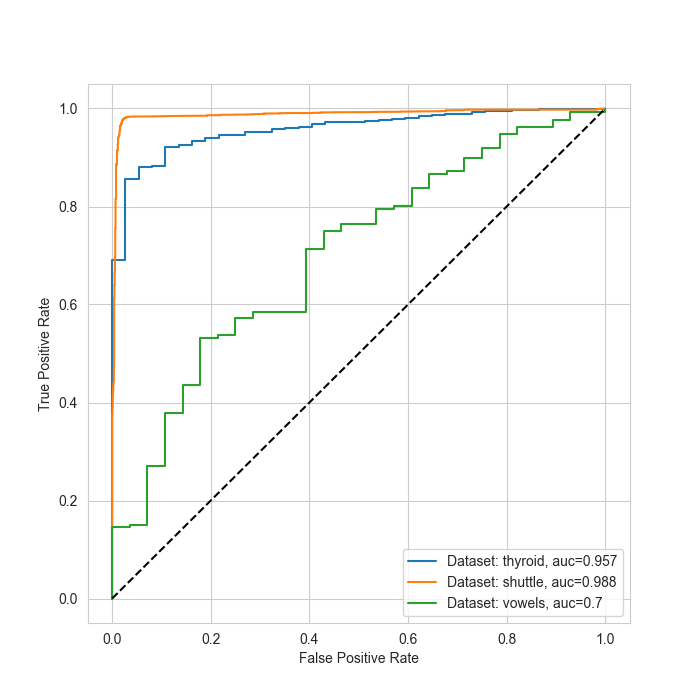

In [40]:
roc_curve_plot(datasets)

# Wnioski

W danej pracy wybrano 3 różne zbiory danych w celu wykrywania anomalii z roznymi parametrami takimi, jak wymiarowosc, ilosc rekordow, ilosc elementow odstajacych. Nastepnie wszystkie zbiory danych zostaly statycznie opisane, aby zrozumiec ich strukture i zawartosc, - rozkłady danych, korelacje miedzy zmiennymi oraz wizualizacja danych w 3D (dla trzech dobranych wymiarów).

Następnie zaimplementowano trzy algorytmy wykrywania elementow odstajacych: __Local Outlier Factor__, __Isolation Forest__ i __One-Class SVM__. Wszystkie trzy algorytmy zostaly zaimplementowane i przetestowane na wszystkich trzech zbiorach danych. Zbiory danych podzielono na zbiory treningowe i testowe z podzialem 1:1, aby eksperymenty przyblizyc do  rzeczywistych warunki, w ktorych algorytmy beda uzywane.

W celu porownania wynikow eksperymentow, zaimplementowano funkcje, ktora oblicza wyniki dla wszystkich trzech algorytmow i wszystkich trzech zbiorow danych. Wyniki eksperymentow zostaly przedstawione w postaci tabeli oraz wykresow ROC.

Warto tez zauwazyc, ze wyniki sa zalezne od wielu czynikow: dobranych parametrow algorytmow, zbiory danych (zaleznosci miedzy cechami, wymiarowosci, rekordow itp.).


#### Local Outlier Factor

Po przeprowadzeniu eksperymentow na wszystkich trzech zbiorach danych, mozna zauwazyc, ze algorytm __LOF__ osiaga najlepsze wyniki na zbiorze danych __Vowels__, a najgorsze na zbiorze danych __Shuttle__. Na zbiorze danych __Thyroid__ wyniki sa przyblizone do wynikow __Vowels__.
Mozna zauwazyc, ze algorytm __LOF__ osiaga najlepsze wyniki na zbiorach danych, ktore maja najmniej wymiarow. Wynika to z faktu, ze algorytm __LOF__ jest algorytmem lokalnym, który mierzy stopień izolacji każdej próbki w porównaniu do jej najbliższych sąsiadów i na tej podstawie przypisuje jej lokalny wynik anomaliowości.

__LOF__ wymaga określenia liczby sąsiadów, które mają być brane pod uwagę przy obliczaniu wyniku. Algorytm oblicza odległość pomiędzy każdą parą próbek w zbiorze danych, a następnie dla każdej próbki oblicza się odległość do jej k-tego najbliższego sąsiada. Następnie porównuje się stopień izolacji każdej próbki do jej sąsiadów i na tej podstawie przypisuje jej wynik anomaliowości. Próbki z wysokimi wynikami LOF są uważane za anomaliczne, ponieważ są słabo podobne do swoich sąsiadów. Algorytm LOF jest skuteczny dla zbiorów danych, w których anomalie występują w małych grupach lub są skupione w określonych obszarach.


#### Isolation Forest

W tym przypadku, algorytm __Isolation Forest__ osiaga najlepsze wyniki na zbiorze danych __Shuttle__, a najgorsze na zbiorze danych __Vowels__. Wyniki zbioru danych __Thyroid__ sa przyblizone do wynikow __Shuttle__. Co jest ciekawe, ponieważ jest to sytuacja odwrotna do algorytmu __LOF__.

Algorytm buduje drzewa decyzyjne poprzez losowe podziały i separacje na kolejnych poziomach, aż do wyizolowania każdej próbki. W ten sposób, im mniej kroków jest potrzebnych, aby wyizolować próbkę, tym bardziej prawdopodobne, że jest to anomalia.

Algorytm Isolation Forest działa w sposób lokalny, ponieważ nie wymaga budowania globalnego modelu i nie ma stałej liczby grup. Zamiast tego, dla każdej próbki może zostać wygenerowany inny model drzewa decyzyjnego, co pozwala na szybkie wykrywanie anomali w dużych zbiorach danych o zmiennej gęstości.

#### One-Class SVM

Podoobnie jak w przypadku algorytmu __Isolation Forest__, algorytm __One-Class SVM__ osiaga najlepsze wyniki na zbiorze danych __Shuttle__, a najgorsze na zbiorze danych __Vowels__. Wyniki __Thyroid__ sa bliskie do wynikow __Shuttle__. Jest to algorytm globalny, który buduje model tylko dla jednej klasy - klasy normalnej, a następnie próbuje zidentyfikować anomalie jako próbki, które są daleko od modelu.

Algorytm One-Class SVM buduje hiperpłaszczyznę, która oddziela próbki od centrów swojej klasy normalnej. Jego celem jest znalezienie granicy decyzyjnej, która oddziela punkty normalne od punktów odstających. Algorytm stara się zminimalizować odległość między hiperpłaszczyzną a najbliższymi punktami normalnymi, jednocześnie maksymalizując margines odstępów między hiperpłaszczyzną a próbkami odstającymi.

W praktyce, algorytm One-Class SVM ma trudności z wykrywaniem anomalii, które są bardzo różnorodne lub nisko związane z danymi normalnymi. W takich przypadkach może wymagać użycia dodatkowych metod przetwarzania danych, takich jak redukcja wymiarowości lub skalowanie.



